#**Homework 3 - MAC De-randomization**

## **Objective**
The homework required the implementation of MAC de-randomization technique on a labelled dataset of sniffed probe requests emitted by 7 different devices, each of them performing MAC address randomization.

### **Clustering** ###
More in detail, the request was to design an online version of a MAC de-randomization algorithm using a clustering approach.

At each probe request analyzed, the choice between creating a new cluster or assigning the probe request to an existing cluster should have been done based on a similarity metric, computed in the following way:
- if the number of features of the probe request under analysis that match the cluster's features is at least $N$, the probe request needs to be assigned to an existing cluster,
- otherwise a new cluster is created.

Additionally, the homework asked to test different values for parameter $N$ and to select the one maximizing the V-Measure and (absolute) error, intended as the differnce between the predicted number of clusters compared their real number.

### **Validation** ###
For validation an additional labelled dataset was provided, with probe requests emitted by 6 different devices. In this case the request was that of performing validation with different test set sizes $K$, where $K$ represents the number of distinct devices in the test set.

E.g.: for $K = 2$, it was asked to create 5 different test-sets composed of 2 randomly selected devices. For each of the 5 experiments, the punctual and average performance needed to be reported. The same approach should have been repeated for values of $K$ between 3 and 6, with a difference for the case with $K = 6$, where it was feasible to generate just a single test set.

### **Estimation of the Number of Devices**
As an extra request it was asked to apply the algorithm deisgned in the preceeding steps on a new unlabelled datatset in order to estimate the number of devices.

---
The notebook is divided in 3 parts, each of them dedicated to one of the 3 main requests of the assignment.

# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import homogeneity_completeness_v_measure

# Part 1: Clustering

## Load Data

As first step we unzip the folder which contains a separate CSV file for labelled probe requests emitted by each of the 7 different devices.

In [49]:
!timeout 7 unzip '/content/drive/MyDrive/[NM-LAB]/Homework3/MAC_derand_lecture-dataset.zip'

Archive:  /content/drive/MyDrive/[NM-LAB]/Homework3/MAC_derand_lecture-dataset.zip
replace __MACOSX/._lecture-dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

We then define a function to group all of the CSV files into a single DataFrame and we call it providing as source directory the one where the previously unzipped folder is located.

In [50]:
def get_df_from_CSVs(path):
  df_list = []

  # Loop through all directories and files in the specified path
  for root, dirs, files in os.walk(path):
    for file in files:
     # Check if the file ends with ".csv"
      if file.endswith(".csv"):
        # Build the file path
        file_path = os.path.join(root, file)
        # Convert data in CSV format into a DataFrame
        df = pd.read_csv(file_path)
        # Append the DataFrame to the list
        df_list.append(df)

  # Combine all DataFrames in the list into a single one
  combine = pd.concat(df_list, ignore_index=True)
  # Convert the 'Timestamp' field type into Datatime
  combine['Timestamp'] = pd.to_datetime(combine['Timestamp'], unit='s')

  return combine

In [51]:
df = get_df_from_CSVs("./lecture-dataset/" )
display(df)

,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,SSID,Supported Rates,Extended Supported Rates,VHT Capabilities,HE Capabilities,Length,Label
0,2021-05-31 14:12:39.190361088,62:5f:2f:de:66:66,6,6.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,NaN,02040b16,0c1218243048606c,NaN,NaN,156,iPhone6_N
1,2021-05-31 14:12:39.210052864,62:5f:2f:de:66:66,6,6.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,NaN,02040b16,0c1218243048606c,NaN,NaN,156,iPhone6_N
2,2021-05-31 14:12:39.231878912,62:5f:2f:de:66:66,6,7.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,NaN,02040b16,0c1218243048606c,NaN,NaN,156,iPhone6_N
3,2021-05-31 14:12:39.252192000,62:5f:2f:de:66:66,6,7.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,NaN,02040b16,0c1218243048606c,NaN,NaN,156,iPhone6_N
4,2021-05-31 14:12:39.273920000,62:5f:2f:de:66:66,6,8.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,NaN,02040b16,0c1218243048606c,NaN,NaN,156,iPhone6_N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4983,2021-06-23 08:54:49.142353920,9a:dd:95:de:40:3e,6,6.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,NaN,02040b16,0c1218243048606c,NaN,NaN,113,iPhoneXR-U
4984,2021-06-23 08:54:49.167303168,9a:dd:95:de:40:3e,11,11.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,NaN,02040b16,0c1218243048606c,NaN,NaN,101,iPhoneXR-U
4985,2021-06-23 08:54:49.187511808,9a:dd:95:de:40:3e,11,11.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,NaN,02040b16,0c1218243048606c,NaN,NaN,101,iPhoneXR-U
4986,2021-06-23 08:59:19.119399168,2e:cf:5a:3c:e6:ee,6,6.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,NaN,02040b16,0c1218243048606c,NaN,NaN,113,iPhoneXR-U


## Inspect Data

We now inspect the number of NaN values for each column of the dataset.

In [52]:
# Count the NaN values in each column
nan_sum = df.isna().sum()
print(nan_sum)

Timestamp                      0
MAC Address                    0
Channel                        0
DS Channel                    29
HT Capabilities                1
Extended Capabilities          1
Vendor Specific Tags         943
SSID                        4561
Supported Rates                0
Extended Supported Rates       1
VHT Capabilities            4988
HE Capabilities             4055
Length                         0
Label                          0
dtype: int64


It seems like that in some columns the number of NaN values is close to the total number of rows, i.e. almost all values are missing. Let's inspect how this is translated in terms of percentages.

In [53]:
# Count the percentage of NaN values for each column
nan_percentage = (nan_sum/len(df))*100
print(nan_percentage)

Timestamp                     0.000000
MAC Address                   0.000000
Channel                       0.000000
DS Channel                    0.581395
HT Capabilities               0.020048
Extended Capabilities         0.020048
Vendor Specific Tags         18.905373
SSID                         91.439455
Supported Rates               0.000000
Extended Supported Rates      0.020048
VHT Capabilities            100.000000
HE Capabilities              81.295108
Length                        0.000000
Label                         0.000000
dtype: float64


## Pre-processing

Given the presence of columns with a high percentage of NaN values, we drop the ones with a NaN percentage over a certain threshold.

In [54]:
columns_to_drop = []

# Retrieve the name of the columns to drop
for i in range(0,len(nan_percentage)):
    if nan_percentage[i] > 80:
        columns_to_drop.append(nan_percentage.index[i])

print(columns_to_drop)

# Drop the columns with a high percentage of NaN values
clean_df = df.drop(columns_to_drop, axis=1)
display(clean_df)

['SSID', 'VHT Capabilities', 'HE Capabilities']


,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label
0,2021-05-31 14:12:39.190361088,62:5f:2f:de:66:66,6,6.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,02040b16,0c1218243048606c,156,iPhone6_N
1,2021-05-31 14:12:39.210052864,62:5f:2f:de:66:66,6,6.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,02040b16,0c1218243048606c,156,iPhone6_N
2,2021-05-31 14:12:39.231878912,62:5f:2f:de:66:66,6,7.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,02040b16,0c1218243048606c,156,iPhone6_N
3,2021-05-31 14:12:39.252192000,62:5f:2f:de:66:66,6,7.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,02040b16,0c1218243048606c,156,iPhone6_N
4,2021-05-31 14:12:39.273920000,62:5f:2f:de:66:66,6,8.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,02040b16,0c1218243048606c,156,iPhone6_N
...,...,...,...,...,...,...,...,...,...,...,...
4983,2021-06-23 08:54:49.142353920,9a:dd:95:de:40:3e,6,6.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,02040b16,0c1218243048606c,113,iPhoneXR-U
4984,2021-06-23 08:54:49.167303168,9a:dd:95:de:40:3e,11,11.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,02040b16,0c1218243048606c,101,iPhoneXR-U
4985,2021-06-23 08:54:49.187511808,9a:dd:95:de:40:3e,11,11.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,02040b16,0c1218243048606c,101,iPhoneXR-U
4986,2021-06-23 08:59:19.119399168,2e:cf:5a:3c:e6:ee,6,6.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,02040b16,0c1218243048606c,113,iPhoneXR-U


Let's now inspect the number of unique elements inside each column.

In [55]:
# Count the number of unique values for each column
unique_elem = clean_df.nunique()
print(unique_elem)

Timestamp                   4988
MAC Address                  718
Channel                        3
DS Channel                    13
HT Capabilities                8
Extended Capabilities          7
Vendor Specific Tags           5
Supported Rates                4
Extended Supported Rates       2
Length                        16
Label                          7
dtype: int64


We notice that in the `timestamp` column, the number of unique values is equal to the number of rows inside the datatset.

More in general, if the number of unique values in some columns is close or equal to the number of data points inside the dataset, we can conclude that column is not really informative. Therefore, we do not include it in the set of features for the clustering algorithm.

We now explicitly define the set of features, avoiding to include the `Label` and `MAC Address` as part of it. The reason for ignoring the former column is trivial. We also avoid the to treat the MAC address as a feature, because the purpose of MAC de-randomization is, given a set of probe request with different (randomized) MAC address, to state if the MAC addresses refer to the same physical device. Therefore it wouldn't make sense to discriminate over the MAC address itself.

In [56]:
features = []

# Select features
for i in range(0, len(unique_elem)):
    if unique_elem[i] < 20 and unique_elem.index[i] != 'Label': # We do not include the ground truth in the set of features
        features.append(unique_elem.index[i])

print(features)

['Channel', 'DS Channel', 'HT Capabilities', 'Extended Capabilities', 'Vendor Specific Tags', 'Supported Rates', 'Extended Supported Rates', 'Length']


We now pre-preprocess data, in order to make the features uniform in terms of data types. In particular, we encode alpha-numerical and integer features features with a floating point representation. This will streamline the comparison between samples in future steps.

In [57]:
def encoder(df,features):
  df_tmp = df.copy()
  label_encoder = LabelEncoder()

  for elem in features:
    # If the feature is not one of the specified columns (these columns have already a numerical encoding), we encoding it
    if elem != 'Length' and elem != 'Channel' and elem != 'DS Channel':
      df_tmp[elem] = label_encoder.fit_transform(df_tmp[elem].astype(str))
    # Convert field to a floating point representation
    df_tmp[elem] = df_tmp[elem].astype(float)
  return df_tmp

We also order data by ascending `Timestamp` to better simulate the online analysis of probe requests. In this way by reading the Dataframe row by row in future steps, we will already find probe requests in the same exact order in which they were genrated.

In [58]:
# Sort by `Timestamp`
clean_df = clean_df.sort_values(by='Timestamp')
# Drop the 'Timestamp' column
clean_df = clean_df.drop(['Timestamp'], axis=1)
# Encode features
encoded_df = encoder(clean_df, features)
display(encoded_df)

,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label
0,62:5f:2f:de:66:66,6.0,6.0,2.0,2.0,1.0,0.0,0.0,156.0,iPhone6_N
1,62:5f:2f:de:66:66,6.0,6.0,2.0,2.0,1.0,0.0,0.0,156.0,iPhone6_N
2,62:5f:2f:de:66:66,6.0,7.0,2.0,2.0,1.0,0.0,0.0,156.0,iPhone6_N
3,62:5f:2f:de:66:66,6.0,7.0,2.0,2.0,1.0,0.0,0.0,156.0,iPhone6_N
4,62:5f:2f:de:66:66,6.0,8.0,2.0,2.0,1.0,0.0,0.0,156.0,iPhone6_N
...,...,...,...,...,...,...,...,...,...,...
1317,28:a0:54:0f:52:67,1.0,3.0,6.0,5.0,5.0,1.0,0.0,132.0,iPhone11-C_a
1312,0f:11:4f:1c:42:5f,11.0,10.0,6.0,5.0,5.0,1.0,0.0,132.0,iPhone11-C_a
1313,0f:11:4f:1c:42:5f,11.0,10.0,6.0,5.0,5.0,1.0,0.0,132.0,iPhone11-C_a
1314,ef:48:f5:b3:ab:5b,11.0,13.0,6.0,5.0,5.0,1.0,0.0,132.0,iPhone11-C_a


We now group data by MAC address and we take a single sample for each distinct MAC address inside the dataset of probe requests.

We do this starting from the assumption that if two MAC addresses are the same, they refer to the same physical device and they also contain similar fields. Therefore, there is no need to keep all the probe requests with the same MAC address inside our dataset, as we assume that it is very likely they will end up in the same cluster once clustering is performed. In the end, as we already discussed, the goal is to understand the mapping bewteen MAC address and and physical device, by looking at their relative features similarity, therefore considering just a single sample could be already enough.

In [59]:
# Group by MAC address
burst_df = encoded_df.groupby(['MAC Address']).first().reset_index()
display(burst_df)

# Count the number of samples for each device
label_count = burst_df["Label"].value_counts()
print(label_count)

,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label
0,00:0f:00:6a:68:8b,1.0,NaN,8.0,7.0,5.0,3.0,2.0,76.0,SamsungJ6_K
1,00:78:b5:8a:40:84,11.0,10.0,6.0,5.0,5.0,1.0,0.0,132.0,iPhone11-C_a
2,00:c6:7e:33:8c:62,11.0,11.0,6.0,5.0,5.0,1.0,0.0,132.0,iPhone11-C_a
3,00:cb:d6:50:04:2c,11.0,10.0,6.0,5.0,5.0,1.0,0.0,132.0,iPhone11-C_a
4,01:31:03:f5:11:4b,11.0,11.0,6.0,5.0,5.0,1.0,0.0,132.0,iPhone11-C_a
...,...,...,...,...,...,...,...,...,...,...
713,fe:7b:b8:60:08:c7,11.0,13.0,6.0,5.0,5.0,1.0,0.0,132.0,iPhone11-C_a
714,fe:9d:55:a5:9f:4a,1.0,1.0,6.0,5.0,5.0,1.0,0.0,143.0,iPhone12_W
715,fe:d8:06:8a:6a:09,1.0,1.0,3.0,3.0,5.0,0.0,0.0,113.0,iPhoneXR-U
716,fe:f9:fc:fb:83:9e,6.0,6.0,2.0,2.0,1.0,0.0,0.0,156.0,iPhone6_N


Label
iPhone11-C_a      334
iPhone12_W        147
HuaweiHonor9_R     89
iPhone6_N          57
iPhoneXR-U         36
S21Ultra-M_a       28
SamsungJ6_K        27
Name: count, dtype: int64


Of course we could have also opted for the fully online approach, without introducing the pre-processing discussed, and look at incoming probe requests one by one from the point of view of a sniffer.

Clearly in this approach grouping data a posteriori by MAC address would not be possible. However, by considering the MAC address as a feature we could make sure that even for smaller values of $N$ data points with the same MAC address are assigned to the same cluster.

It is to say that the performance we could get with this approach might be different from the one where we group by MAC address and it could potentially lead to a more accurate overall solution. However, the main drawback would be the low computational efficiency, typical of any online algorithm, due to the fact without grouping data we would need to deal with a dataset almost 7 times larger compared to the case we group by MAC address ($\frac{4988\ Samples}{717 \ Samples} ≃ 7$). This could be an issue considering that the clustering needs to be repeated with various values of $N$, with different test set sizes in the validation step and also on a very large unlabelled datatset for the last step.

In the all the experiments reported in this notebook we will always group by MAC address and apply an online approach to data pre-processed in this way.

## Clustering

We now define some utilitiy functions useful for performing clustering over the data points.

This function is used to determine the centroid of a given cluster. The centroid is computed as the column-wise mode over the non-NaN values in each column. If the column is made of NaN values only, we set the corresponding centroid field to NaN. In the end we get a single-row DataFrame where the value of each fields represents the most frequent value among that of all the samples in the cluster.

In [60]:
def determine_centroid(group_df):
  mode_values = []

  # Iterate over the columns inside the df
  for col in group_df:
    # Filter the non-NaN values inside the current column
    non_nan_values = group_df[col].dropna()

    # If the columns is made by NaN values only
    if len(non_nan_values) == 0:
      # Set the mode for this column to NaN
      mode_values.append(np.nan) # Append NaN if all values are NaN
    else:
      # Otherwise take as mode the first more recurrent value
      mode_values.append(non_nan_values.mode()[0])

  return pd.DataFrame([mode_values], columns=group_df.columns)

This function is in charge of computing the similarity between a probe request and all the clusters. In particular, it retrieves the centroid of each cluster in the current set of identified clusters and it counts the number of matching features between the probe request under analysis and each of the centroids.

Notice how in case both the centroid and the probe request have a feature set to NaN, this is also considered a valid match. This is based on the assumption that it might not be a case that both values are missing, thus it could be that this is discriminative characteristic of the data generation mechanism. Indeed, it could be there is a particular device emitting probe requests with that missing parameter.

The function returns a list of scores, where the list index represents the cluster number. E.g. in postion 0 we have the similarity score between the probe request and cluster 0.



In [61]:
def compute_similarity_metric(probe_req_df,clusters_df):
  scores = []

  # Take the DataFrame with all probe requests received so far and group it by cluster ID
  grouped_df = clusters_df.groupby('Cluster ID')
  # Determine the centroid of each identified cluster
  centroids_df = grouped_df.apply(determine_centroid)
  # Asjust indexes
  centroids_df.reset_index(drop=True, inplace=True)

  # Iterate of the set of all the centroids
  for idx, cluster in centroids_df.iterrows():
    matching_features = 0
    # Compute the number of matching features between a centroid and the probe request
    for feature in features:
      if (cluster[feature] == probe_req_df.iloc[0][feature]) or (pd.isna(cluster[feature]) and pd.isna(probe_req_df.iloc[0][feature])):
        matching_features += 1
    # Append the score to the list of scores
    scores.append(matching_features)
  return scores

This function assigns a cluster ID to a probe request. In particular, it scans the list of similarity scores and it checks if the scores overcome the threshold. But instead of assigning the sample to the first cluster whose similarity score overcomes the threshold, it chooses the one whose score overcomes the threshold and it is also the highest value registered. If none of the scores overcomes the threshold a new clusters ID is generated.

Notice that the function argument `clusters_num` is the number of clusters already identified. E.g. if the `clusters_num` = 5, it means that current set of clusters IDs is made of indexes go from 0 to 4. So in case a new cluster needs to be generated, we return `clusters_num`= 5, representing the ID of the new cluster.

In [62]:
def select_cluster(threshold,scores,clusters_num):
  # ID of the selected cluster
  selected_cluster_id = None
  # Maximum score
  max_score = -1

  # Iterate over the list of scores
  for idx in range(len(scores)):
    score = scores[idx]
    # If the score exceeds the threshold and it is higher than the maximum score regsitered so far,
    # consider the corresponding cluster ID as a good candidate
    if score >= threshold and score > max_score:
      max_score = score
      selected_cluster_id = idx

  # If none of the scores exceeded the threshold
  if selected_cluster_id == None:
    # Return a new clsuter ID
    return clusters_num

  # Return the ID of the most similar cluster
  return selected_cluster_id

This function helps to better interpet the results.

In [63]:
def plot_heatmap(df, column1, column2, threshold, colormap='YlGnBu'):
   crosstab = pd.crosstab(df[column1], df[column2])
   sns.set_theme(style="whitegrid",font_scale=0.8)
   plt.figure(figsize=(10,5))
   sns.heatmap(crosstab,annot=True, fmt="d", cmap=colormap)
   plt.title(f"Heatmap of {column1} vs {column2} with N ={threshold}")
   plt.xlabel(column2)
   plt.ylabel(column1)

   plt.show()

This is the main function resposnible for performing clustering. It analyzes probe requests in the input dataset one by one and:
*   the first time a probe request is received, it automatically generates a new cluster with that sample
*   in all the other cases it computes the similarity score between the sample and the clusters already identified and:
  *   if there is at least one score thar overcomes the threshold ($N$ in the text of the assignment), it assigns the probe request the ID of the cluster which is the most similar among all the clusters overcoming the the threshold.
  *   if no similarity score overcomes the threshold, a new cluster ID is generated and it is assigned to the current probe request

Probe requests that have been already read are appended to a separate dataset, with a new field, that is the one with the cluster ID they were assigned to.

Then, in case the input dataset is unlabelled, only the total number of clusters identified is returned. Otherwise, performance metrics are computed and returned by the function.






In [64]:
def perform_clustering(threshold,df,is_unlabelled):
  # List of all rows considered so far
  clusters_list = []
  # Number of clusters identified so far
  clusters_num = 0

  # Scan the datatset of probe requests row by row
  for idx,probe_req in df.iterrows():
    probe_req_df = pd.DataFrame([probe_req])

    # Add the first cluster
    if len(clusters_list) == 0:
      # Set the cluster ID to 0
      selected_cluster_id = clusters_num
      # Increment the current number of clusters
      clusters_num += 1

    else: # If there exists at least one cluster
      clusters_df = pd.concat(clusters_list, ignore_index=True)
      # Compute the similarity score between the probe request and the current clusters
      scores = compute_similarity_metric(probe_req_df,clusters_df)
      # Select the cluster ID, based on the similarity scores and the threshold
      selected_cluster_id = select_cluster(threshold,scores,clusters_num)

      # In case a new clusters was identified
      if selected_cluster_id == clusters_num:
        # Increment the current number of clusters
        clusters_num += 1

    # Assign the cluster ID to the probe request
    probe_req_df['Cluster ID'] = selected_cluster_id
    # Add the probe request to the list of those already cosnidered
    clusters_list.append(probe_req_df)

  # In case the dataset is not labelled
  if is_unlabelled:
    # Return the number of clusters identified
    return clusters_num

  # Otherwise compute the performance metrics
  clusters_df = pd.concat(clusters_list, ignore_index=True)
  unique_labels_num = len(np.unique(clusters_df["Label"]))
  abs_error = abs(unique_labels_num - clusters_num)
  homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(clusters_df["Label"], clusters_df["Cluster ID"])

  plot_heatmap(clusters_df,'Label','Cluster ID',threshold)
  # and return them
  return abs_error, v_measure, clusters_num, homogeneity, completeness

We now inspect the behaviour of the clustering alogrithm designed on the labelled dataset with data from 7 devices at varying values of parameter $N$. More in detail, the range considered is $N \in [1,7]$, which doesn't include the two extreme values $0$ and $8$, since we already know that for $N = 0$ we would get a single cluster with all the probe requests inside and for $N = 8$, which is the total number of features we selected, we would obtain a new cluster for every unique combination of features, thus producing a very high (and excessive) number of clusters.

In [65]:
print("Number of Features:", len(features))

Number of Features: 8


N: 1


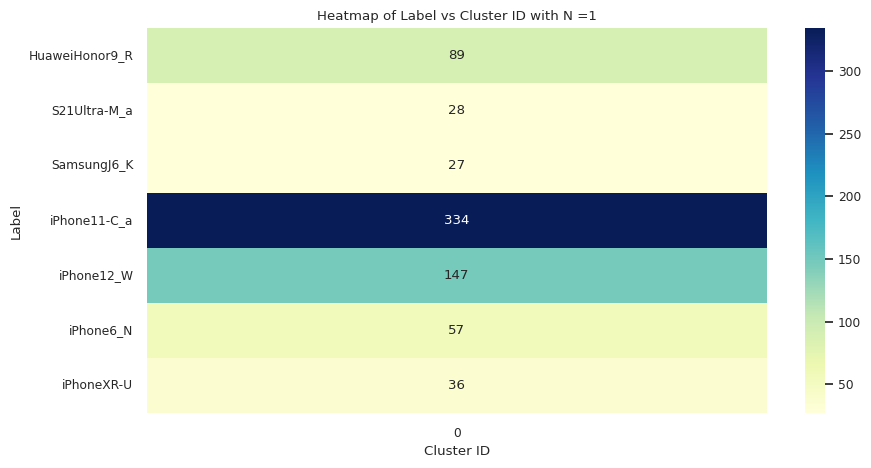

Absolute Error: 6
V-Measure: 0.0
Number of Clusters: 1
Homogeneity: 0.0
Completeness: 1.0


N: 2


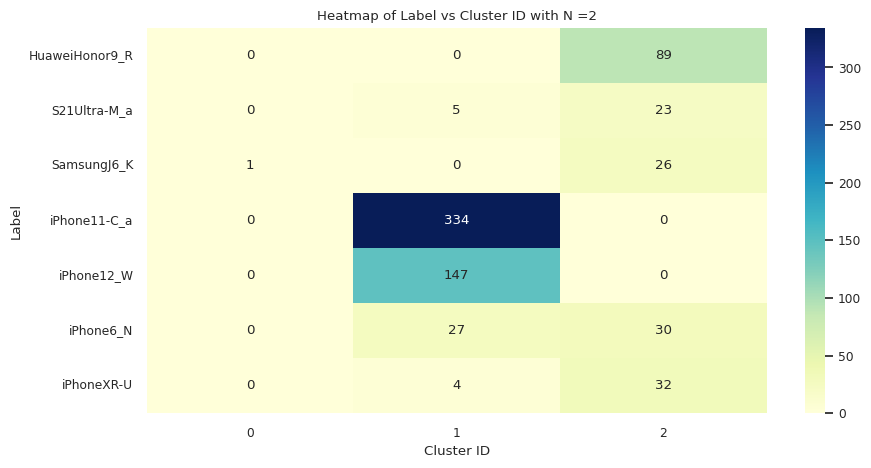

Absolute Error: 4
V-Measure: 0.47147367692428677
Number of Clusters: 3
Homogeneity: 0.327802983596369
Completeness: 0.8393447871506328


N: 3


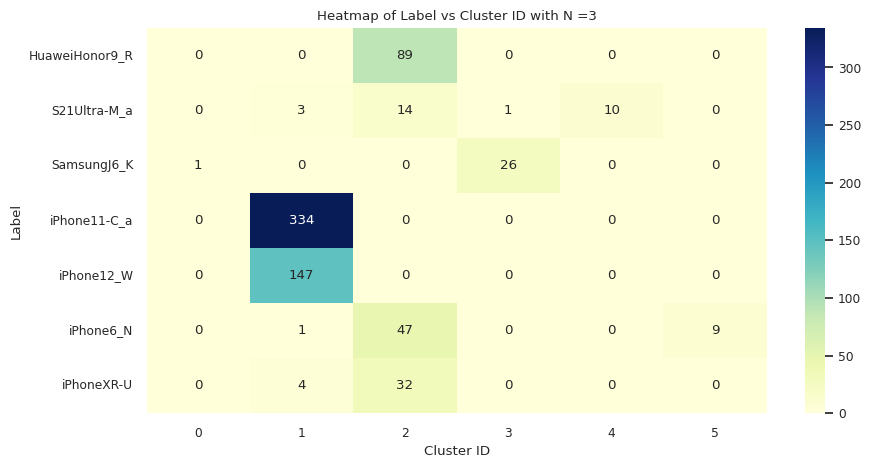

Absolute Error: 1
V-Measure: 0.6255767413594658
Number of Clusters: 6
Homogeneity: 0.4866709221568737
Completeness: 0.8754472688920926


N: 4


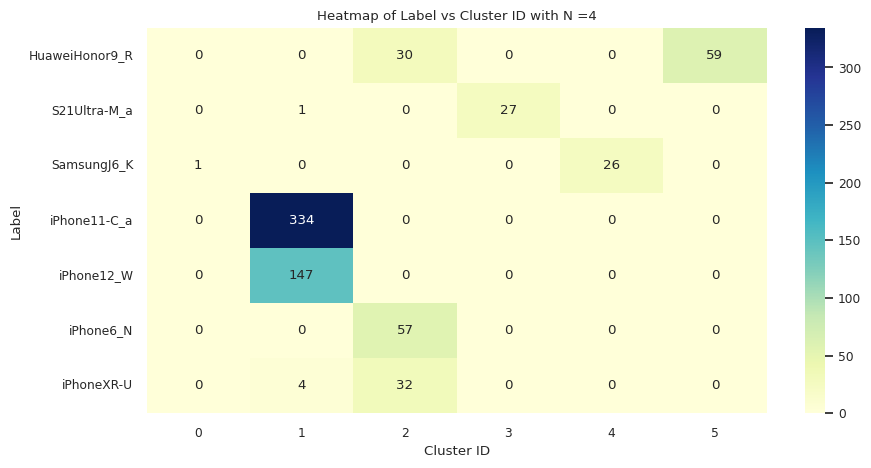

Absolute Error: 1
V-Measure: 0.7118485126561375
Number of Clusters: 6
Homogeneity: 0.5915933132988158
Completeness: 0.8934665110094434


N: 5


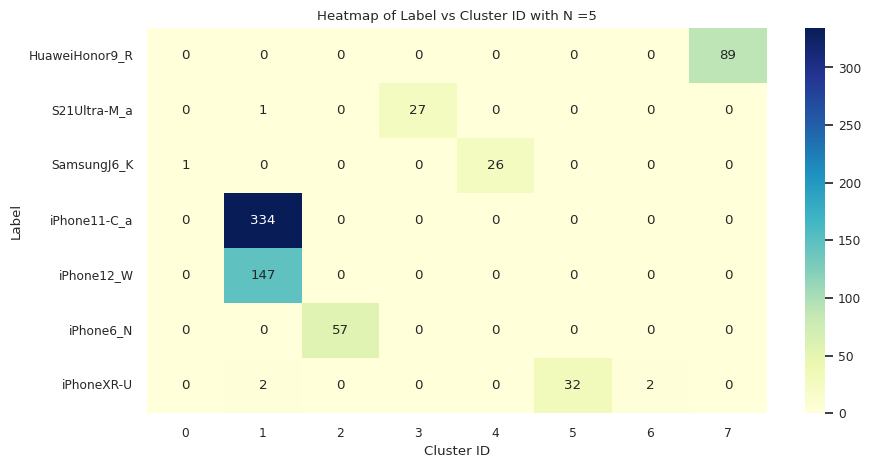

Absolute Error: 1
V-Measure: 0.8228383697363578
Number of Clusters: 8
Homogeneity: 0.7141187237920837
Completeness: 0.9706065106214176


N: 6


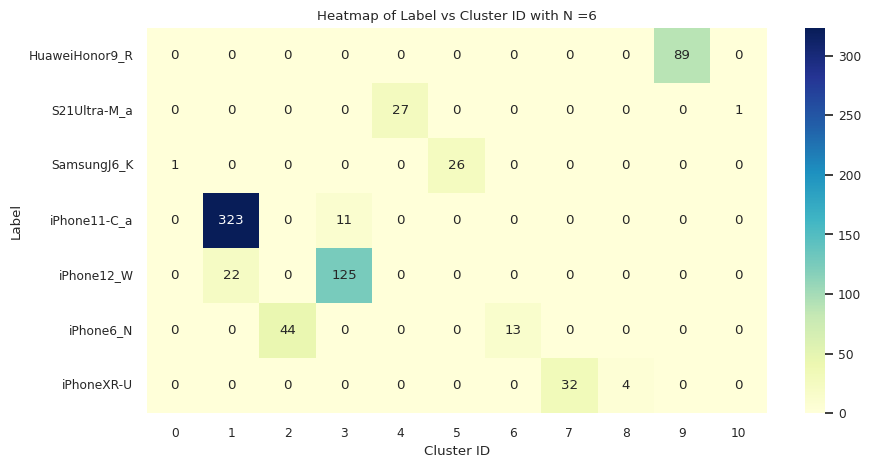

Absolute Error: 4
V-Measure: 0.8748190438134628
Number of Clusters: 11
Homogeneity: 0.8914767599803605
Completeness: 0.8587724254854536


N: 7


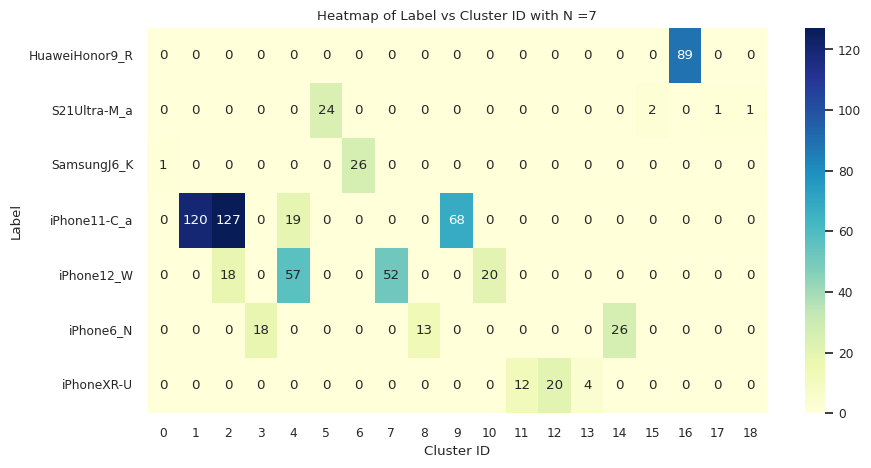

Absolute Error: 12
V-Measure: 0.7147924932726408
Number of Clusters: 19
Homogeneity: 0.9121952315146362
Completeness: 0.587627520649457




In [66]:
clustering = {'N':[], 'Absolute Error': [], 'V-Measure':[], 'Clustsers Number':[], 'Homogeneity':[], 'Completeness':[]}

# Inspect clustering performance at varying N
for N in range(1,len(features)): # from 1 to 7
  print("N:",N)
  abs_error, v_measure, clusters_num, homogeneity, completeness = perform_clustering(N,burst_df,False)
  clustering['N'].append(N)
  clustering['Absolute Error'].append(abs_error)
  clustering['V-Measure'].append(v_measure)
  clustering['Clustsers Number'].append(clusters_num)
  clustering['Homogeneity'].append(homogeneity)
  clustering['Completeness'].append(completeness)

  print("Absolute Error:",abs_error)
  print("V-Measure:", v_measure)
  print("Number of Clusters:",clusters_num)
  print("Homogeneity:",homogeneity)
  print("Completeness:",completeness)
  print("\n")

performances_df = pd.DataFrame(clustering)

Having inspected the perfromance of the clustering algortithm at varying $N$, we now select the $N$ parameter which yields the best overall performance.

In [67]:
display(performances_df)

,N,Absolute Error,V-Measure,Clustsers Number,Homogeneity,Completeness
0,1,6,0.000000,1,0.000000,1.000000
1,2,4,0.471474,3,0.327803,0.839345
2,3,1,0.625577,6,0.486671,0.875447
3,4,1,0.711849,6,0.591593,0.893467
4,5,1,0.822838,8,0.714119,0.970607
5,6,4,0.874819,11,0.891477,0.858772
6,7,12,0.714792,19,0.912195,0.587628


From the summary of the performances at varying $N$, we can see that values of $N$ in range $[1,2]$ have both high absolute error and low V-Measure, which means that the number of clusters identified is not close to the real number of clusters and clusters are not very homogenous. The performance starts improving from $N = 3$ and it gets better and better until $N = 5$, where it reaches the lowest absolute error of 1. By inspecting the heatmap plotted in the previous steps we could say that for $N = 5$ all clusters seem sufficiently complete and homogenous, except for cluster 1, which is not very homogenous as it containst probe requests coming from 2 IPhone devices. The inability to distinguish between these 2 devices is almost overcome with $N = 6$ (see the heatmap for this scenario), but the absolute error for this value of $N$ is equal to 4, which could be a hint of the fact that we are already slowly starting to overfit. Indeed the error increases even more for $N = 7$.

All these considerations lead to the choice of 5 as the best value of parameter $N$.

In [68]:
best_N = 5
print("Best N:",best_N)

Best N: 5



We can better interpret this result by looking at the following plot, which shows the absolute error and the V-Measure at varying $N$.

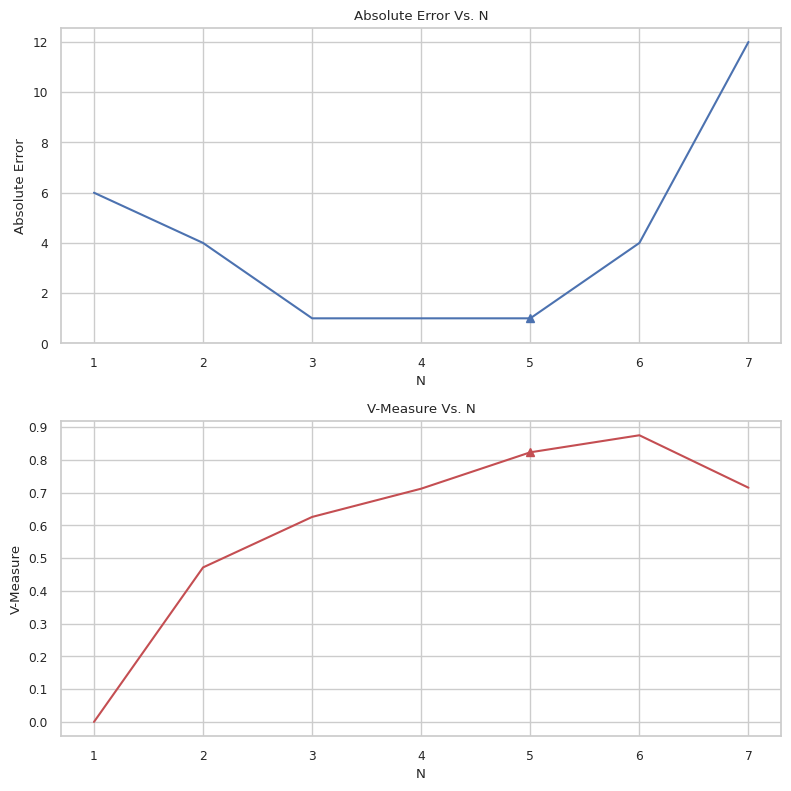

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

ax1.plot(performances_df['N'],performances_df['Absolute Error'],'b')
ax1.plot(performances_df[performances_df['N'] == best_N]['N'],performances_df[performances_df['N'] == best_N]['Absolute Error'],'^b')
ax1.set_title("Absolute Error Vs. N")
ax1.set_yticks(np.arange(0,performances_df['Absolute Error'].max()+1,2))
ax1.set_xlabel("N")
ax1.set_ylabel("Absolute Error")
ax1.grid(True)

ax2.plot(performances_df['N'],performances_df['V-Measure'],'r')
ax2.plot(performances_df[performances_df['N'] == best_N]['N'],performances_df[performances_df['N'] == best_N]['V-Measure'],'^r')
ax2.set_title("V-Measure Vs. N")
ax2.set_yticks(np.arange(performances_df['V-Measure'].min(),performances_df['V-Measure'].max()+0.1,0.10))
ax2.set_xlabel("N")
ax2.set_ylabel('V-Measure')
ax2.grid(True)

plt.tight_layout()

# Part 2: Validation

We now want to validate our model against a different labelled dataset of probe requests, genertaed by 6 different devices.

## Load Test Data

As first step we unzip the folder which contains a separate CSV file for labelled probe requests by each of the 6 different devices.

In [91]:
!timeout 5 unzip '/content/drive/MyDrive/[NM-LAB]/Homework3/MAC_derand_challenge-dataset.zip'

Archive:  /content/drive/MyDrive/[NM-LAB]/Homework3/MAC_derand_challenge-dataset.zip
replace __MACOSX/._challenge-dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

We now merge these files into a single DataFrame.

In [92]:
validation_df = get_df_from_CSVs('./challenge-dataset/')
display(validation_df)

,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,SSID,Supported Rates,Extended Supported Rates,VHT Capabilities,HE Capabilities,Length,Label
0,2021-06-16 13:23:32.718988032,02:fd:74:4d:50:ab,1,1,631117ffff000000000000000000000000000000000000...,88001400040,00904c0408bf0c3230900ffaff0000faff0000,NaN,02040b16,0c1218243048606c,NaN,NaN,154,SamsungS7_I
1,2021-06-16 13:23:32.759255040,02:fd:74:4d:50:ab,1,1,631117ffff000000000000000000000000000000000000...,88001400040,00904c0408bf0c3230900ffaff0000faff0000,NaN,02040b16,0c1218243048606c,NaN,NaN,154,SamsungS7_I
2,2021-06-16 13:23:32.802566144,02:fd:74:4d:50:ab,1,2,631117ffff000000000000000000000000000000000000...,88001400040,00904c0408bf0c3230900ffaff0000faff0000,NaN,02040b16,0c1218243048606c,NaN,NaN,154,SamsungS7_I
3,2021-06-16 13:23:32.842981120,02:fd:74:4d:50:ab,1,2,631117ffff000000000000000000000000000000000000...,88001400040,00904c0408bf0c3230900ffaff0000faff0000,NaN,02040b16,0c1218243048606c,NaN,NaN,154,SamsungS7_I
4,2021-06-16 13:23:32.886509824,02:fd:74:4d:50:ab,1,3,631117ffff000000000000000000000000000000000000...,88001400040,00904c0408bf0c3230900ffaff0000faff0000,NaN,02040b16,0c1218243048606c,NaN,NaN,154,SamsungS7_I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7498,2021-06-29 13:54:55.115344896,5c:c3:07:07:af:59,11,11,210017ff00000000000000000080010000000000000000...,88001400040,00904c0408bf0c3250800ffeff0000feff0000,NaN,02040b16,0c1218243048606c,NaN,NaN,155,HuaweiHonor9_R
7499,2021-06-29 13:54:55.156310016,5c:c3:07:07:af:59,11,12,210017ff00000000000000000080010000000000000000...,88001400040,00904c0408bf0c3250800ffeff0000feff0000,NaN,02040b16,0c1218243048606c,NaN,NaN,155,HuaweiHonor9_R
7500,2021-06-29 13:54:55.196523008,5c:c3:07:07:af:59,11,12,210017ff00000000000000000080010000000000000000...,88001400040,00904c0408bf0c3250800ffeff0000feff0000,NaN,02040b16,0c1218243048606c,NaN,NaN,155,HuaweiHonor9_R
7501,2021-06-29 13:54:55.238227968,5c:c3:07:07:af:59,11,13,210017ff00000000000000000080010000000000000000...,88001400040,00904c0408bf0c3250800ffeff0000feff0000,NaN,02040b16,0c1218243048606c,NaN,NaN,155,HuaweiHonor9_R


## Inspect Test Data

In [93]:
nan_sum = validation_df.isna().sum()
print(nan_sum)

Timestamp                      0
MAC Address                    0
Channel                        0
DS Channel                     0
HT Capabilities              267
Extended Capabilities        267
Vendor Specific Tags        2237
SSID                        7105
Supported Rates                0
Extended Supported Rates       0
VHT Capabilities            6080
HE Capabilities             3843
Length                         0
Label                          0
dtype: int64


In [94]:
nan_percentage = (nan_sum/len(validation_df))*100
print(nan_percentage)

Timestamp                    0.000000
MAC Address                  0.000000
Channel                      0.000000
DS Channel                   0.000000
HT Capabilities              3.558577
Extended Capabilities        3.558577
Vendor Specific Tags        29.814741
SSID                        94.695455
Supported Rates              0.000000
Extended Supported Rates     0.000000
VHT Capabilities            81.034253
HE Capabilities             51.219512
Length                       0.000000
Label                        0.000000
dtype: float64


## Pre-processing Test Data

We drop the same columns we dropped for the previous dataset for coherence and also because the considerations done for the first collection of data points hold also in this case. We then encode data exactly as we have done in the previous scenario.

In [95]:
clean_validation_df = validation_df.drop(columns_to_drop, axis=1)
display(clean_validation_df)

,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label
0,2021-06-16 13:23:32.718988032,02:fd:74:4d:50:ab,1,1,631117ffff000000000000000000000000000000000000...,88001400040,00904c0408bf0c3230900ffaff0000faff0000,02040b16,0c1218243048606c,154,SamsungS7_I
1,2021-06-16 13:23:32.759255040,02:fd:74:4d:50:ab,1,1,631117ffff000000000000000000000000000000000000...,88001400040,00904c0408bf0c3230900ffaff0000faff0000,02040b16,0c1218243048606c,154,SamsungS7_I
2,2021-06-16 13:23:32.802566144,02:fd:74:4d:50:ab,1,2,631117ffff000000000000000000000000000000000000...,88001400040,00904c0408bf0c3230900ffaff0000faff0000,02040b16,0c1218243048606c,154,SamsungS7_I
3,2021-06-16 13:23:32.842981120,02:fd:74:4d:50:ab,1,2,631117ffff000000000000000000000000000000000000...,88001400040,00904c0408bf0c3230900ffaff0000faff0000,02040b16,0c1218243048606c,154,SamsungS7_I
4,2021-06-16 13:23:32.886509824,02:fd:74:4d:50:ab,1,3,631117ffff000000000000000000000000000000000000...,88001400040,00904c0408bf0c3230900ffaff0000faff0000,02040b16,0c1218243048606c,154,SamsungS7_I
...,...,...,...,...,...,...,...,...,...,...,...
7498,2021-06-29 13:54:55.115344896,5c:c3:07:07:af:59,11,11,210017ff00000000000000000080010000000000000000...,88001400040,00904c0408bf0c3250800ffeff0000feff0000,02040b16,0c1218243048606c,155,HuaweiHonor9_R
7499,2021-06-29 13:54:55.156310016,5c:c3:07:07:af:59,11,12,210017ff00000000000000000080010000000000000000...,88001400040,00904c0408bf0c3250800ffeff0000feff0000,02040b16,0c1218243048606c,155,HuaweiHonor9_R
7500,2021-06-29 13:54:55.196523008,5c:c3:07:07:af:59,11,12,210017ff00000000000000000080010000000000000000...,88001400040,00904c0408bf0c3250800ffeff0000feff0000,02040b16,0c1218243048606c,155,HuaweiHonor9_R
7501,2021-06-29 13:54:55.238227968,5c:c3:07:07:af:59,11,13,210017ff00000000000000000080010000000000000000...,88001400040,00904c0408bf0c3250800ffeff0000feff0000,02040b16,0c1218243048606c,155,HuaweiHonor9_R


In [96]:
unique_elem = clean_validation_df.nunique()
print(unique_elem)

Timestamp                   7502
MAC Address                 1509
Channel                        3
DS Channel                    13
HT Capabilities                5
Extended Capabilities          5
Vendor Specific Tags           7
Supported Rates                3
Extended Supported Rates       2
Length                        13
Label                          6
dtype: int64


In [97]:
clean_validation_df = clean_validation_df.sort_values(by='Timestamp')
clean_validation_df = clean_validation_df.drop(['Timestamp'], axis=1)
encoded_validation_df = encoder(clean_validation_df, features)
display(encoded_validation_df)

,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label
697,02:00:00:00:00:00,1.0,1.0,1.0,2.0,0.0,1.0,1.0,123.0,SamsungM31_A
698,02:00:00:00:00:00,1.0,1.0,1.0,2.0,0.0,1.0,1.0,123.0,SamsungM31_A
699,02:00:00:00:00:00,1.0,2.0,1.0,2.0,0.0,1.0,1.0,123.0,SamsungM31_A
700,02:00:00:00:00:00,1.0,3.0,1.0,2.0,0.0,1.0,1.0,123.0,SamsungM31_A
701,02:00:00:00:00:00,1.0,3.0,1.0,2.0,0.0,1.0,1.0,123.0,SamsungM31_A
...,...,...,...,...,...,...,...,...,...,...
3681,ea:82:7f:89:cc:08,11.0,9.0,5.0,5.0,6.0,0.0,0.0,84.0,GooglePixel3A_V
3682,ea:82:7f:89:cc:08,11.0,10.0,5.0,5.0,6.0,0.0,0.0,84.0,GooglePixel3A_V
3683,ea:82:7f:89:cc:08,11.0,11.0,5.0,5.0,6.0,0.0,0.0,84.0,GooglePixel3A_V
3684,ea:82:7f:89:cc:08,11.0,12.0,5.0,5.0,6.0,0.0,0.0,84.0,GooglePixel3A_V


For the reasons we already discussed we group by MAC address.

In [98]:
burst_validation_df = encoded_validation_df.groupby(['MAC Address']).first().reset_index()
display(burst_validation_df)

label_count = burst_validation_df["Label"].value_counts()
print(label_count)

,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label
0,02:00:00:00:00:00,1.0,1.0,1.0,2.0,0.0,1.0,1.0,123.0,SamsungM31_A
1,02:02:70:30:b6:43,1.0,3.0,2.0,3.0,7.0,2.0,0.0,143.0,iPhone12_W
2,02:0b:5b:9e:41:54,1.0,1.0,3.0,4.0,2.0,0.0,0.0,154.0,SamsungS7_I
3,02:0b:72:cb:7d:eb,1.0,1.0,3.0,4.0,2.0,0.0,0.0,154.0,SamsungS7_I
4,02:0c:01:7e:50:d6,1.0,1.0,3.0,4.0,2.0,0.0,0.0,154.0,SamsungS7_I
...,...,...,...,...,...,...,...,...,...,...
1504,fe:c5:50:16:eb:8c,11.0,11.0,2.0,3.0,7.0,2.0,0.0,131.0,iPhone12_W
1505,fe:ed:a5:45:e8:b9,11.0,11.0,4.0,1.0,1.0,0.0,0.0,143.0,XiaomiRedmiNote9S_T
1506,fe:f5:97:dd:58:86,6.0,8.0,2.0,3.0,7.0,2.0,0.0,143.0,iPhone12_W
1507,fe:f9:ac:47:0d:b7,11.0,11.0,2.0,3.0,7.0,2.0,0.0,131.0,iPhone12_W


Label
iPhone12_W             1206
XiaomiRedmiNote9S_T     138
HuaweiHonor9_R           89
SamsungS7_I              38
GooglePixel3A_V          23
SamsungM31_A             15
Name: count, dtype: int64


## Validation

We now define some utility functions useful for performing validation.

This is a utility function used to check if the combination of devices selected for the test set has already been used for validation. It basically works with a list of lists of devices names, represeninting a collection of combination of devices already used and it checks if a given list represents a combination already used in the past.

In [99]:
def already_selected(elem_sublist,elem_list):
  # Iterate over the list of lists
  for lst in elem_list:
    # If the sublist we want to analze is already contained in the list of lists
    if set(elem_sublist) == set(lst):
      # We say that the combination has already been used
      return True
  # Otherwise we say the combination was never used before
  return False

This is the function we use for performing validation. Notice that it is parametric with respetct to parameter $K$, that is the number of devices in the in the test set. The function randomaly selects the name of the $K$ devices to be placed in the test set and it does it for `n_test_sets` times. Each time it makes sure that the combination of devices names has never been used before when considering that specific $K$. Then the average performance obetained across the `n_test_sets` tests sets is computed and returned as output.

In [100]:
np.random.seed(42)

def perform_validation(K,n_test_sets,validation_df,labels_list):
  abs_errors_list = []
  v_measure_list = []
  devices_list = []

  # Generate multiple test sets for a given number of devices K
  for i in range (1,n_test_sets+1):
    # Select the K different devices
    devices = np.random.choice(labels_list, size=K, replace=False)
    # In case these combination of devices was already selected,
    # try with another combination until you find one which has been never drawn before
    while already_selected(devices,devices_list):
      devices = np.random.choice(labels_list, size=K, replace=False)
    devices_list.append(devices)
    print(f"> Test Set {i}\n  Labels: {devices}")

    # Perform clustering on the dataset filtered by the K selected devices
    abs_error, v_measure, clusters_num, homogeneity, completeness = perform_clustering(best_N,validation_df[validation_df['Label'].isin(devices)],False)
    abs_errors_list.append(abs_error)
    v_measure_list.append(v_measure)
    # Print performance indexes
    print(f"  Absolute Error: {abs_error}")
    print(f"  V-Measure: {v_measure}")
    print("  Number of Clusters:",clusters_num)
    print("  Homogeneity:",homogeneity)
    print("  Completeness:",completeness)
    print("\n")

  # Print the average performance across all test sets with K devices used
  mean_abs_error = float(sum(abs_errors_list))/float(len(abs_errors_list))
  mean_v_measure = sum(v_measure_list)/len(v_measure_list)
  return mean_abs_error, mean_v_measure

We now make some experiments with test sets with probe requests from an increasing number of unique devices. More in detail we create 5 versions of test sets for each $K$ in range $[2,5]$. For $K = 6$, instead only one test set can be generated.

The same clustering algorithm developed in part 1 is repeated on all the different test sets generated with a value of $N = 5$ (the optimal value previosuly identified). Then, the average perfomance across the 5 test sets generated for each $K$ is collected for future analysis.

--- K = 2 ------------------------
> Test Set 1
  Labels: ['GooglePixel3A_V' 'HuaweiHonor9_R']


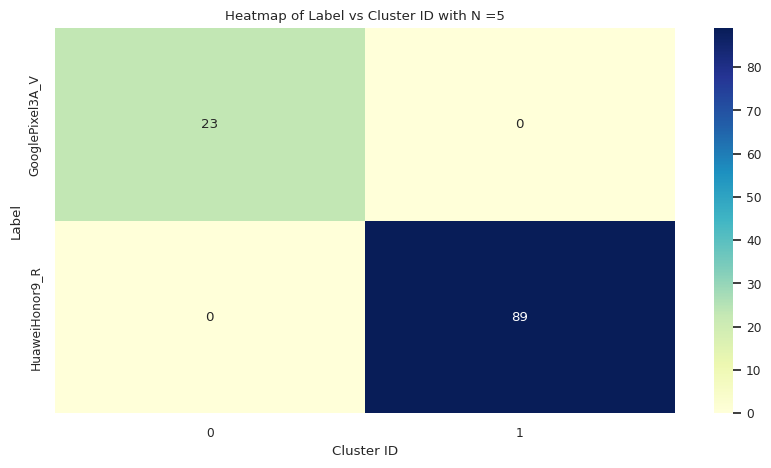

  Absolute Error: 0
  V-Measure: 1.0
  Number of Clusters: 2
  Homogeneity: 1.0
  Completeness: 1.0


> Test Set 2
  Labels: ['SamsungS7_I' 'GooglePixel3A_V']


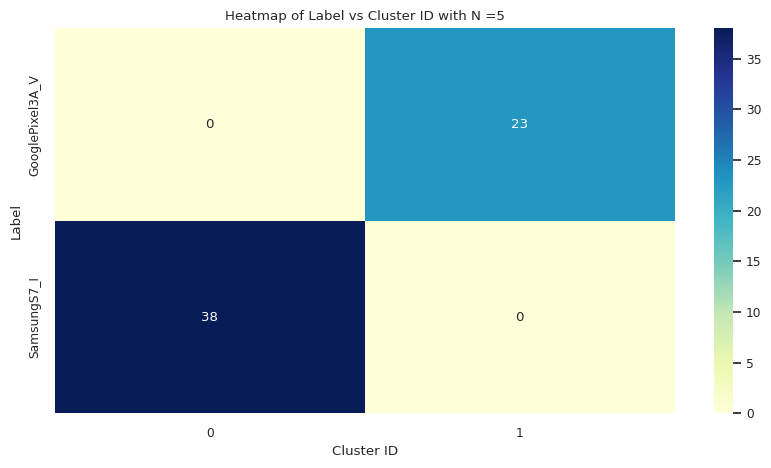

  Absolute Error: 0
  V-Measure: 1.0
  Number of Clusters: 2
  Homogeneity: 1.0
  Completeness: 1.0


> Test Set 3
  Labels: ['XiaomiRedmiNote9S_T' 'HuaweiHonor9_R']


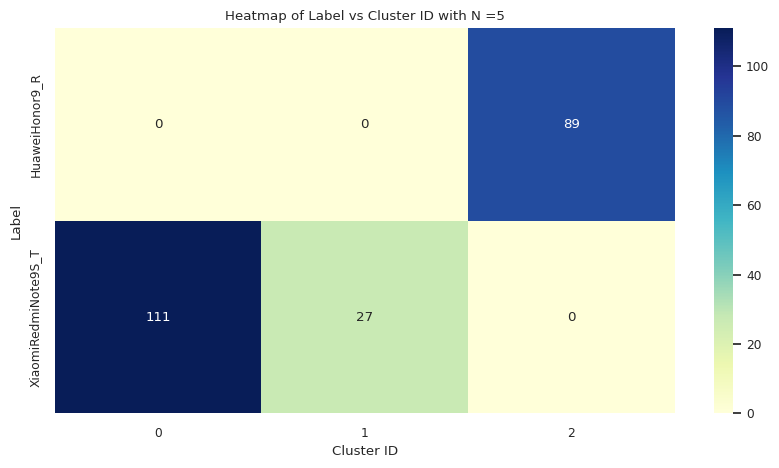

  Absolute Error: 1
  V-Measure: 0.8167448281609909
  Number of Clusters: 3
  Homogeneity: 1.0000000000000002
  Completeness: 0.6902524895721437


> Test Set 4
  Labels: ['GooglePixel3A_V' 'iPhone12_W']


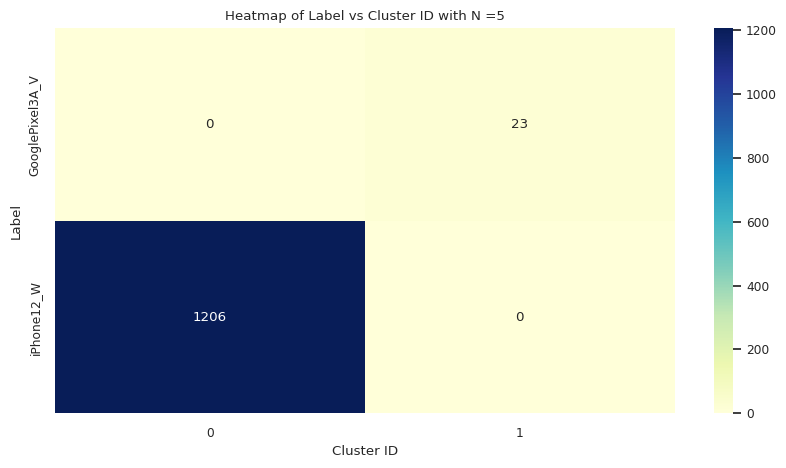

  Absolute Error: 0
  V-Measure: 1.0
  Number of Clusters: 2
  Homogeneity: 1.0
  Completeness: 1.0


> Test Set 5
  Labels: ['SamsungM31_A' 'iPhone12_W']


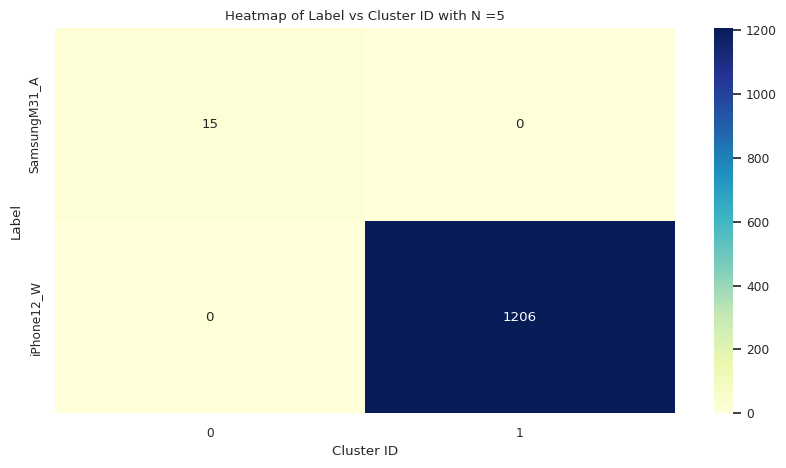

  Absolute Error: 0
  V-Measure: 1.0
  Number of Clusters: 2
  Homogeneity: 1.0
  Completeness: 1.0


Mean Absolute Error (K = 2): 0.2
Mean V-Measure (K = 2): 0.9633489656321981


--- K = 3 ------------------------
> Test Set 1
  Labels: ['iPhone12_W' 'SamsungM31_A' 'GooglePixel3A_V']


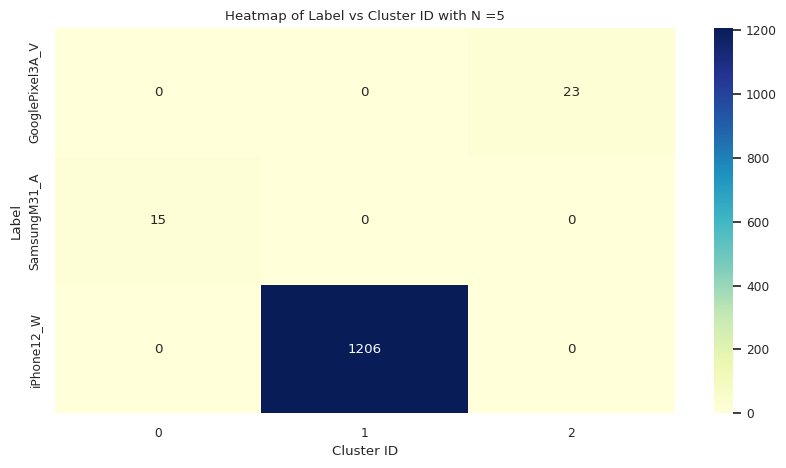

  Absolute Error: 0
  V-Measure: 1.0000000000000002
  Number of Clusters: 3
  Homogeneity: 1.0
  Completeness: 1.0000000000000002


> Test Set 2
  Labels: ['GooglePixel3A_V' 'SamsungS7_I' 'HuaweiHonor9_R']


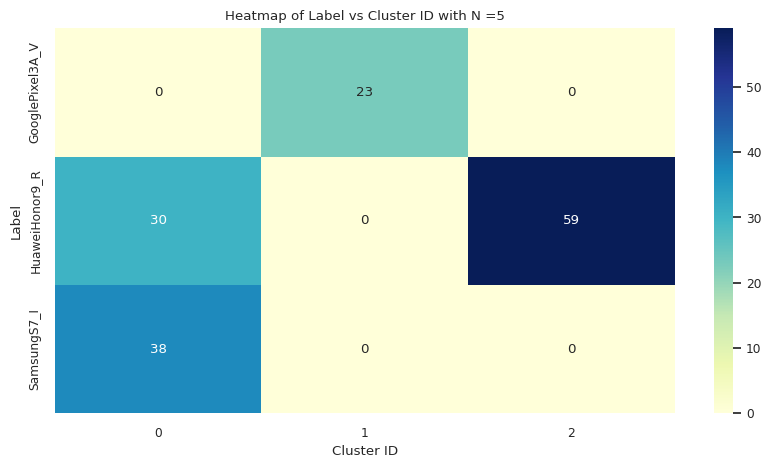

  Absolute Error: 0
  V-Measure: 0.647509917417577
  Number of Clusters: 3
  Homogeneity: 0.6708404007474604
  Completeness: 0.6257476688405224


> Test Set 3
  Labels: ['GooglePixel3A_V' 'HuaweiHonor9_R' 'SamsungM31_A']


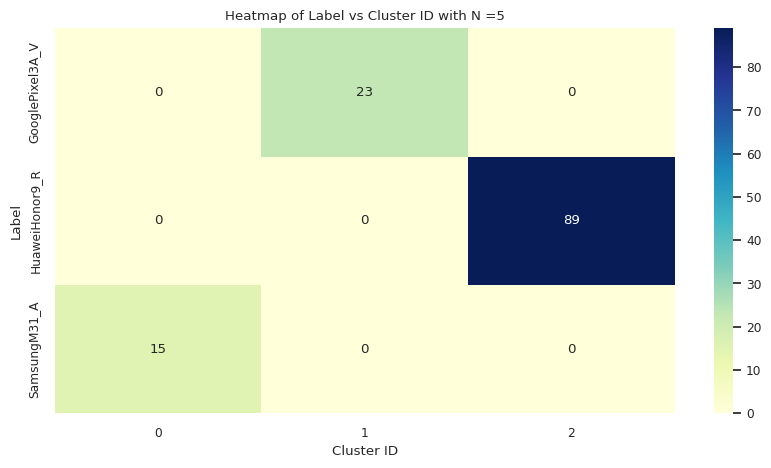

  Absolute Error: 0
  V-Measure: 1.0
  Number of Clusters: 3
  Homogeneity: 1.0
  Completeness: 1.0


> Test Set 4
  Labels: ['GooglePixel3A_V' 'HuaweiHonor9_R' 'XiaomiRedmiNote9S_T']


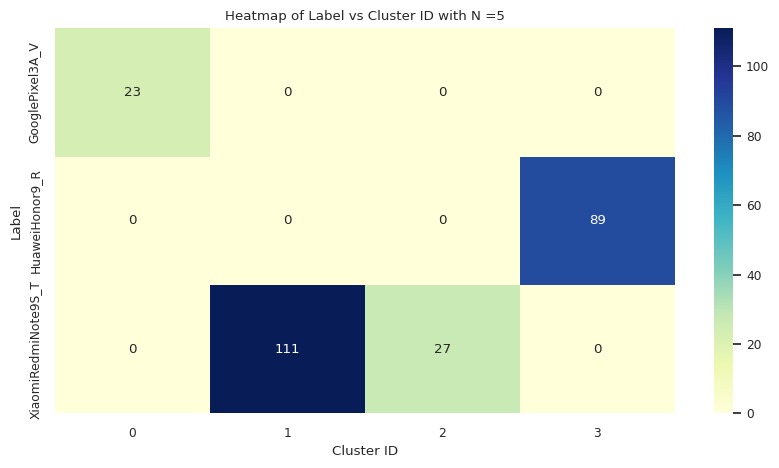

  Absolute Error: 1
  V-Measure: 0.8702667454942354
  Number of Clusters: 4
  Homogeneity: 1.0000000000000002
  Completeness: 0.7703294047717125


> Test Set 5
  Labels: ['HuaweiHonor9_R' 'SamsungS7_I' 'XiaomiRedmiNote9S_T']


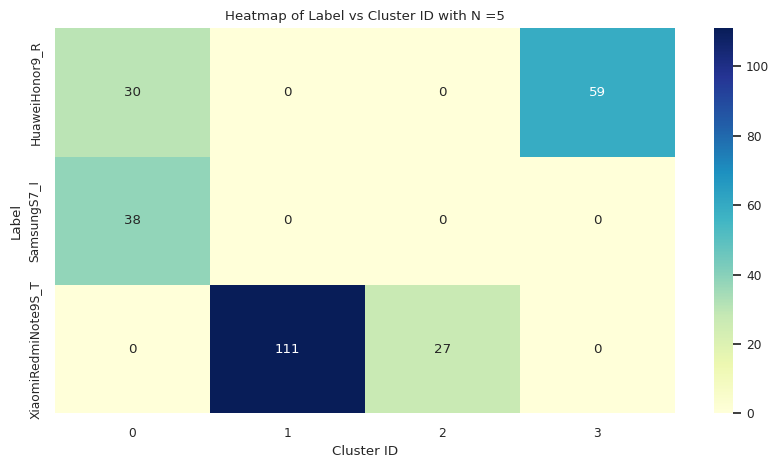

  Absolute Error: 1
  V-Measure: 0.7138985824644014
  Number of Clusters: 4
  Homogeneity: 0.8211832081969545
  Completeness: 0.6314074724530357


Mean Absolute Error (K = 3): 0.4
Mean V-Measure (K = 3): 0.8463350490752429


--- K = 4 ------------------------
> Test Set 1
  Labels: ['iPhone12_W' 'SamsungS7_I' 'HuaweiHonor9_R' 'SamsungM31_A']


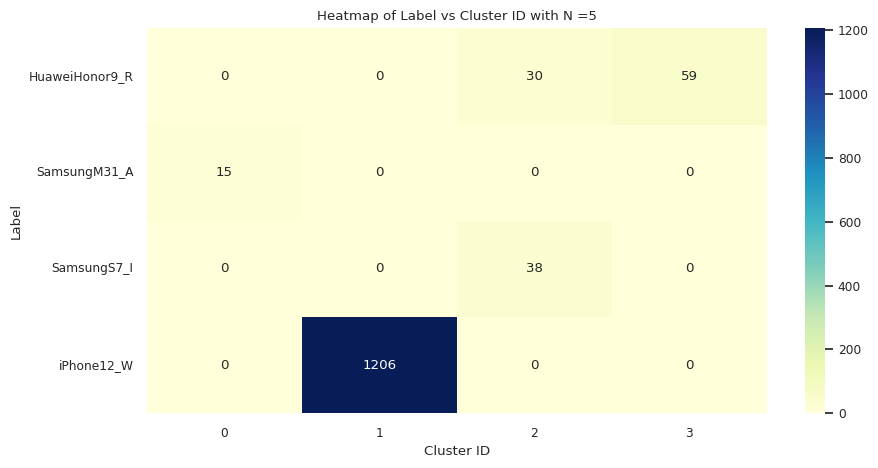

  Absolute Error: 0
  V-Measure: 0.9114008678646802
  Number of Clusters: 4
  Homogeneity: 0.9194381574252677
  Completeness: 0.9035028769209795


> Test Set 2
  Labels: ['iPhone12_W' 'SamsungM31_A' 'XiaomiRedmiNote9S_T' 'HuaweiHonor9_R']


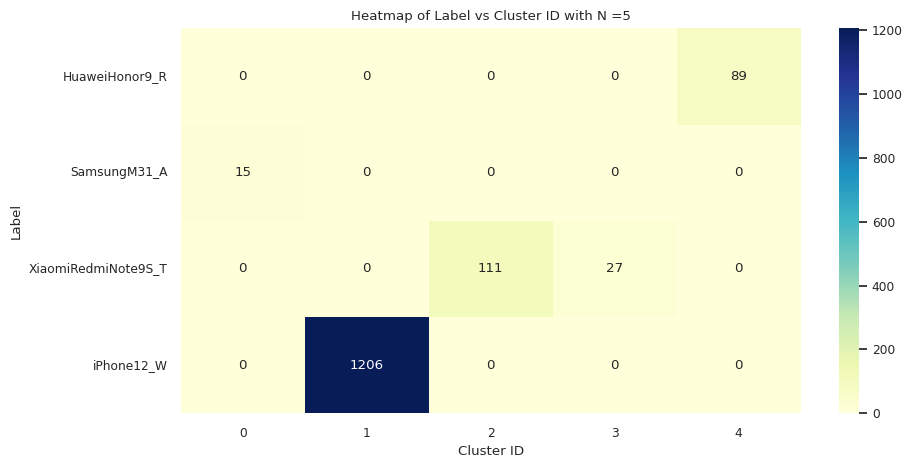

  Absolute Error: 1
  V-Measure: 0.9619266858019024
  Number of Clusters: 5
  Homogeneity: 1.0
  Completeness: 0.9266461941033349


> Test Set 3
  Labels: ['SamsungS7_I' 'SamsungM31_A' 'XiaomiRedmiNote9S_T' 'iPhone12_W']


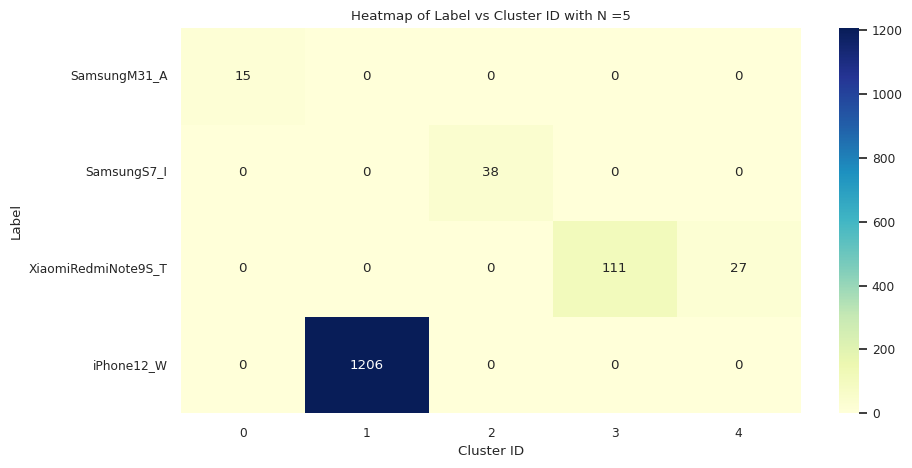

  Absolute Error: 1
  V-Measure: 0.9536477776806902
  Number of Clusters: 5
  Homogeneity: 1.0
  Completeness: 0.9114022576134698


> Test Set 4
  Labels: ['XiaomiRedmiNote9S_T' 'HuaweiHonor9_R' 'GooglePixel3A_V' 'SamsungM31_A']


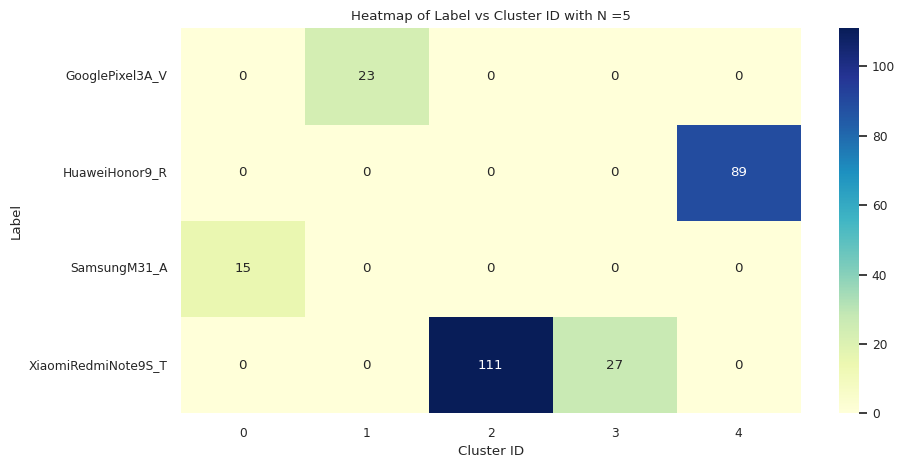

  Absolute Error: 1
  V-Measure: 0.8935958750650179
  Number of Clusters: 5
  Homogeneity: 1.0000000000000002
  Completeness: 0.8076577580705692


> Test Set 5
  Labels: ['XiaomiRedmiNote9S_T' 'iPhone12_W' 'HuaweiHonor9_R' 'SamsungS7_I']


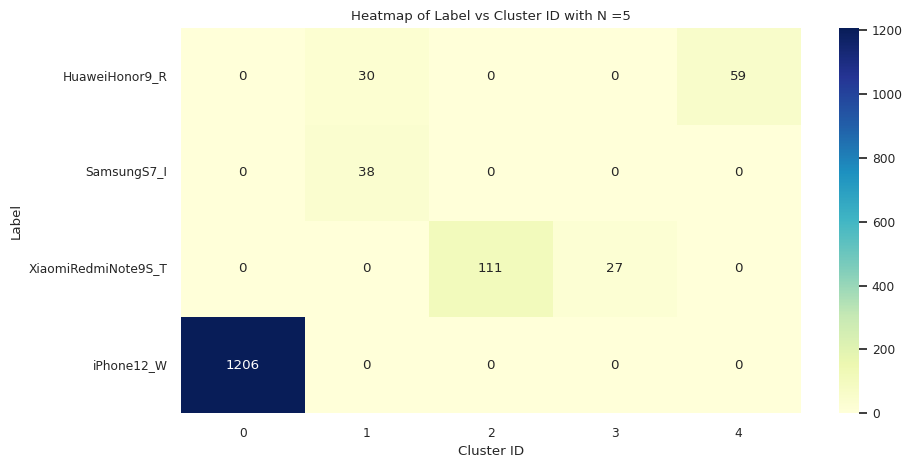

  Absolute Error: 1
  V-Measure: 0.9135966688170107
  Number of Clusters: 5
  Homogeneity: 0.9511237632068703
  Completeness: 0.8789184726049545


Mean Absolute Error (K = 4): 0.8
Mean V-Measure (K = 4): 0.9268335750458603


--- K = 5 ------------------------
> Test Set 1
  Labels: ['GooglePixel3A_V' 'SamsungM31_A' 'iPhone12_W' 'XiaomiRedmiNote9S_T'
 'HuaweiHonor9_R']


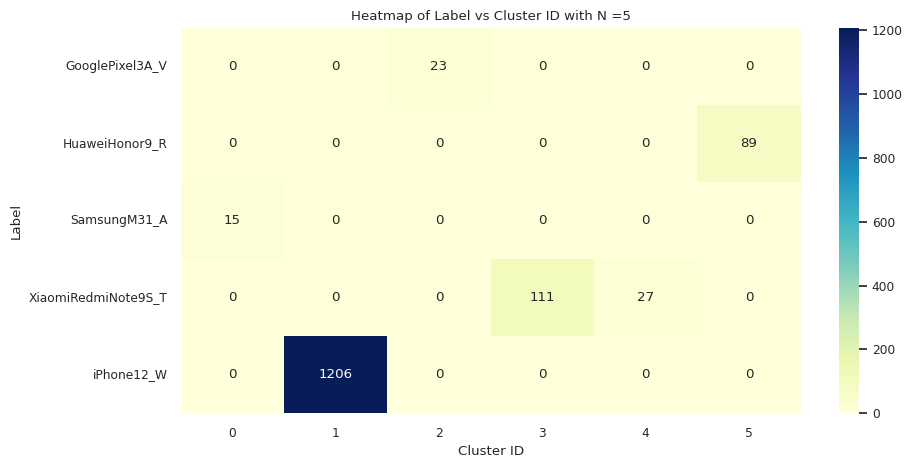

  Absolute Error: 1
  V-Measure: 0.9663731747538228
  Number of Clusters: 6
  Homogeneity: 1.0
  Completeness: 0.9349343023519763


> Test Set 2
  Labels: ['XiaomiRedmiNote9S_T' 'SamsungM31_A' 'GooglePixel3A_V' 'iPhone12_W'
 'SamsungS7_I']


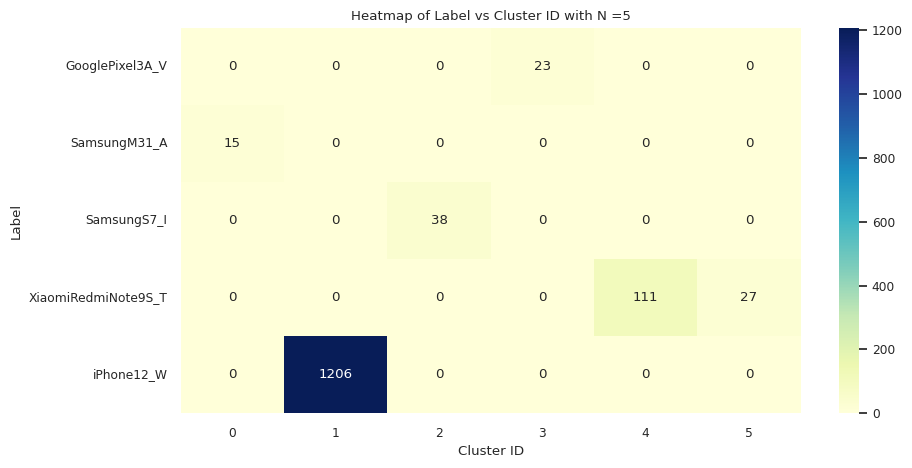

  Absolute Error: 1
  V-Measure: 0.9600367663341554
  Number of Clusters: 6
  Homogeneity: 1.0
  Completeness: 0.9231449105657799


> Test Set 3
  Labels: ['GooglePixel3A_V' 'XiaomiRedmiNote9S_T' 'SamsungM31_A' 'HuaweiHonor9_R'
 'SamsungS7_I']


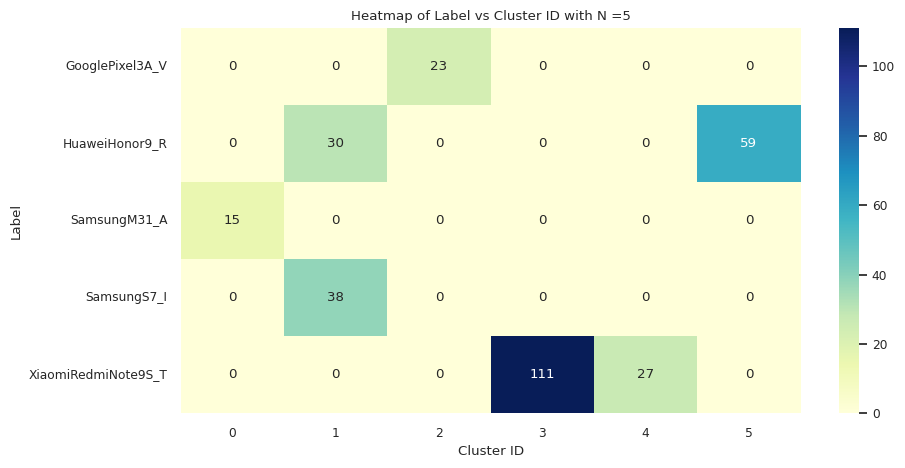

  Absolute Error: 1
  V-Measure: 0.8048501757934021
  Number of Clusters: 6
  Homogeneity: 0.8835903854162509
  Completeness: 0.7389953937843314


> Test Set 4
  Labels: ['SamsungS7_I' 'GooglePixel3A_V' 'SamsungM31_A' 'HuaweiHonor9_R'
 'iPhone12_W']


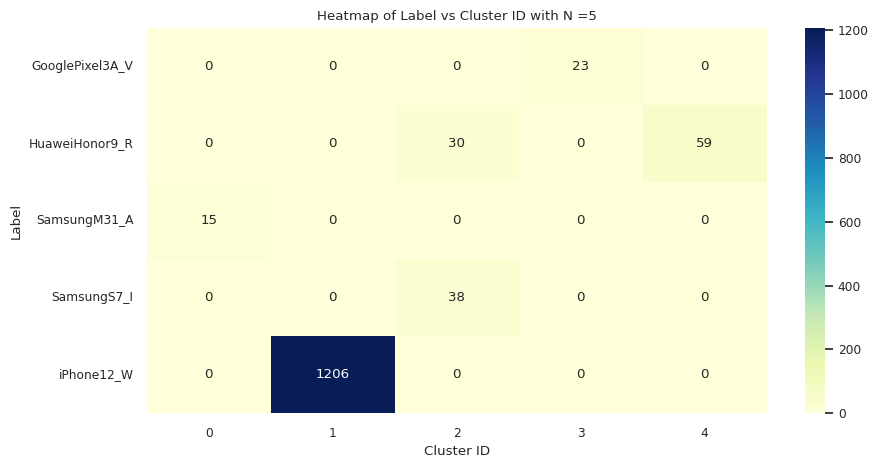

  Absolute Error: 0
  V-Measure: 0.926163345815247
  Number of Clusters: 5
  Homogeneity: 0.9329599603261308
  Completeness: 0.9194650418031592


> Test Set 5
  Labels: ['HuaweiHonor9_R' 'XiaomiRedmiNote9S_T' 'SamsungM31_A' 'SamsungS7_I'
 'iPhone12_W']


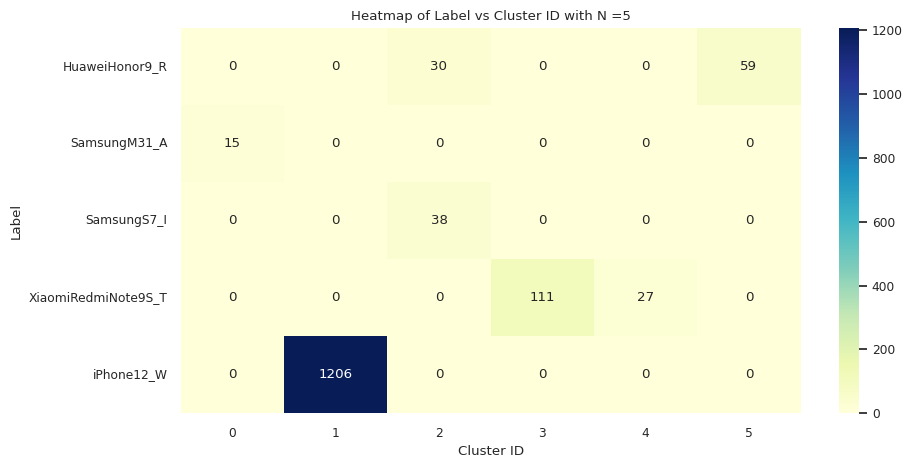

  Absolute Error: 1
  V-Measure: 0.9203196193779268
  Number of Clusters: 6
  Homogeneity: 0.9550703702142653
  Completeness: 0.8880089350505904


Mean Absolute Error (K = 5): 0.8
Mean V-Measure (K = 5): 0.9155486164149108


--- K = 6 ------------------------
> Test Set 1
  Labels: ['HuaweiHonor9_R' 'XiaomiRedmiNote9S_T' 'iPhone12_W' 'SamsungS7_I'
 'GooglePixel3A_V' 'SamsungM31_A']


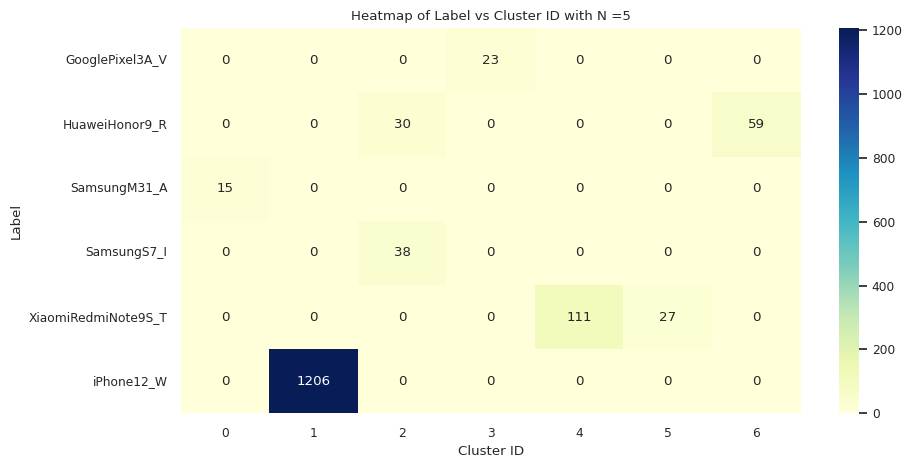

  Absolute Error: 1
  V-Measure: 0.9282454591313102
  Number of Clusters: 7
  Homogeneity: 0.959690937381526
  Completeness: 0.898795302789945


Mean Absolute Error (K = 6): 1.0
Mean V-Measure (K = 6): 0.9282454591313102




In [101]:
unique_labels = np.unique(burst_validation_df['Label'].values)
validation = {'K':[], 'Mean Absolute Error': [], 'Mean V-Measure':[]}
# Number of test sets to be generated for a given value of K
num_test_sets = 5

# Iterate over values of K from 2 to the unique number of devices in the dataset
for K in range(2,len(unique_labels)+1):
  print("--- K =", K,"------------------------")
  # For K equal to the maximum number of devices only 1 test set can be generated
  if K == len(unique_labels):
    num_test_sets = 1
  # Perform validation
  mean_abs_error, mean_v_measure = perform_validation(K,num_test_sets,burst_validation_df,unique_labels)
  validation['K'].append(K)
  validation['Mean Absolute Error'].append(mean_abs_error)
  validation['Mean V-Measure'].append(mean_v_measure)

  # Print average performances for the given value of K
  print(f'Mean Absolute Error (K = {K}): {mean_abs_error}')
  print(f'Mean V-Measure (K = {K}): {mean_v_measure}')
  print("\n")

We now inspect the average performance at varying values of $K$.

In [102]:
validation_performances_df = pd.DataFrame(validation)
display(validation_performances_df)

,K,Mean Absolute Error,Mean V-Measure
0,2,0.2,0.963349
1,3,0.4,0.846335
2,4,0.8,0.926834
3,5,0.8,0.915549
4,6,1.0,0.928245


Heatmaps plotted for each experiment suggest that the algorithm struggles in identifying the 'XiaomiRedmiNote9S_T' device, as probe requests belonging to this class tend to be split in two different clusters. Another weakness of the model consists in being unable to distinguish 'HuaweiHonor9_R' from 'SamsungS7_I' most of the times, letting frames generated by the two devices enter the same cluster.

From the summary of average performances achieved with an incresing test set length $K$, it is clear that with $K = 2$ we have both the lowest absolute error, but also the highest V-Measure. However, it is also to notice that for higher values of K the drop in performance is not significant, as the V-Measure keeps oscillating around 0.9 until $K = 6$ and the error never gets higher than 1.

We can conclude that the clustering algorithm with the parameter $N$ set to 5 performs reasonably well even on a dataset different from the one used to identify the optimal value of $N$, despite not being able to *perfectly* identify the mapping between MAC address and physical device.

The perfomances achieved at varying $K$ can also be inspected by looking at the following plots.

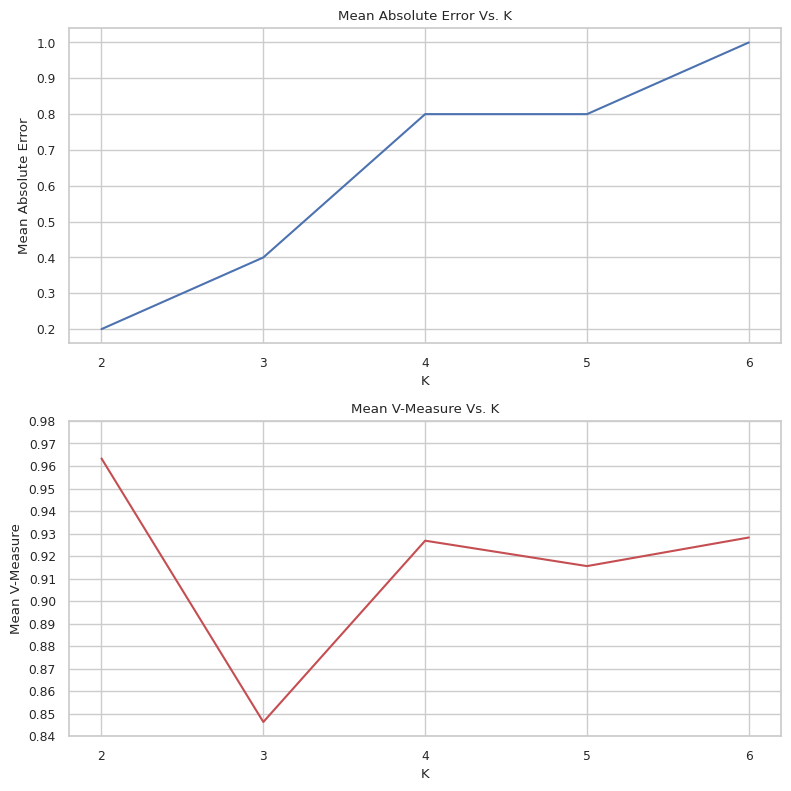

In [103]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

ax1.plot(validation_performances_df['K'],validation_performances_df['Mean Absolute Error'],'b')
ax1.set_title("Mean Absolute Error Vs. K")
ax1.set_xticks(np.arange(validation_performances_df['K'].min(),validation_performances_df['K'].max()+1,1))
ax1.set_xlabel("K")
ax1.set_ylabel("Mean Absolute Error")
ax1.grid(True)

ax2.plot(validation_performances_df['K'],validation_performances_df['Mean V-Measure'],'r')
ax2.set_title("Mean V-Measure Vs. K")
ax2.set_yticks(np.arange(0.84,0.98,0.01))
ax2.set_xticks(np.arange(validation_performances_df['K'].min(),validation_performances_df['K'].max()+1,1))
ax2.set_xlabel("K")
ax2.set_ylabel('Mean V-Measure')
ax2.grid(True)

plt.tight_layout()

# Part 3: Estimation of the Number of Devices

We proceed with the estimation of the number of devices which emitted probe requests in a new unlabelled dataset.

## Load Unlabelled Dataset

We first load the dataset.

In [83]:
unlabelled_df = pd.read_csv('/content/drive/MyDrive/[NM-LAB]/Homework3/MAC_derand_unlabelled-challenge.csv')
display(unlabelled_df)

,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,SSID,Supported Rates,Extended Supported Rates,VHT Capabilities,HE Capabilities,Length
0,1.623419e+09,40:f3:08:d8:f3:08,11,9.0,2d1017ff00000000000000000000000000000000000000...,0000080000000040,001018020000100000,NaN,02040b16,0c1218243048606c,NaN,NaN,165
1,1.623404e+09,40:f3:08:d8:f3:08,11,3.0,2d1017ff00000000000000000000000000000000000000...,0000080000000040,001018020000100000,NaN,02040b16,0c1218243048606c,NaN,NaN,165
2,1.623421e+09,40:f3:08:d8:f3:08,11,12.0,2d1017ff00000000000000000000000000000000000000...,0000080000000040,001018020000100000,NaN,02040b16,0c1218243048606c,NaN,NaN,165
3,1.623405e+09,40:f3:08:d8:f3:08,1,3.0,2d1017ff00000000000000000000000000000000000000...,0000080000000040,001018020000100000,NaN,02040b16,0c1218243048606c,NaN,NaN,165
4,1.626771e+09,b2:a6:bb:76:7e:ff,1,3.0,ad0113ffff000000000000000000000000000000000000...,00000a82004000000001,0050f208002700,NaN,02040b16,0c1218243048606c,92f99133faff6203faff6203,020009,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20459,1.697027e+09,ec:c0:0f:94:26:87,1,3.0,ef0113ffff000000000000000000000000000000000000...,04000a8200400040800120,0050f208002800,1857de08b31a,02040b16,0c1218243048606c,92f19033faff6203faff6203,2303010002400006304c090d008008020000fafffaff19...,185
20460,1.697027e+09,ec:c0:0f:94:26:87,1,3.0,ef0113ffff000000000000000000000000000000000000...,04000a8200400040800120,0050f208002800,e26731af925,02040b16,0c1218243048606c,92f19033faff6203faff6203,2303010002400006304c090d008008020000fafffaff19...,184
20461,1.697027e+09,ec:c0:0f:94:26:87,1,3.0,ef0113ffff000000000000000000000000000000000000...,04000a8200400040800120,0050f208002800,03af9014bf2b48a844,02040b16,0c1218243048606c,92f19033faff6203faff6203,2303010002400006304c090d008008020000fafffaff19...,191
20462,1.697027e+09,ec:c0:0f:94:26:87,1,3.0,ef0113ffff000000000000000000000000000000000000...,04000a8200400040800120,0050f208002800,0864a4b6b,02040b16,0c1218243048606c,92f19033faff6203faff6203,2303010002400006304c090d008008020000fafffaff19...,182


## Inspect Unlabelled Dataset

We inspect data like we did in previous scenarios.

In [84]:
nan_sum = unlabelled_df.isna().sum()
print(nan_sum)

Timestamp                       0
MAC Address                     0
Channel                         0
DS Channel                      1
HT Capabilities                 0
Extended Capabilities           0
Vendor Specific Tags         3036
SSID                        19529
Supported Rates                 0
Extended Supported Rates        0
VHT Capabilities            17857
HE Capabilities             15619
Length                          0
dtype: int64


In [85]:
nan_percentage = (nan_sum/len(unlabelled_df))*100
print(nan_percentage)

Timestamp                    0.000000
MAC Address                  0.000000
Channel                      0.000000
DS Channel                   0.004887
HT Capabilities              0.000000
Extended Capabilities        0.000000
Vendor Specific Tags        14.835809
SSID                        95.431001
Supported Rates              0.000000
Extended Supported Rates     0.000000
VHT Capabilities            87.260555
HE Capabilities             76.324277
Length                       0.000000
dtype: float64


## Pre-Processing Unlabelled Dataset

We perform the same pre-processing seen for previous datasets.

In [86]:
clean_unlabelled_df = unlabelled_df.drop(columns_to_drop, axis=1)
display(clean_unlabelled_df)

,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length
0,1.623419e+09,40:f3:08:d8:f3:08,11,9.0,2d1017ff00000000000000000000000000000000000000...,0000080000000040,001018020000100000,02040b16,0c1218243048606c,165
1,1.623404e+09,40:f3:08:d8:f3:08,11,3.0,2d1017ff00000000000000000000000000000000000000...,0000080000000040,001018020000100000,02040b16,0c1218243048606c,165
2,1.623421e+09,40:f3:08:d8:f3:08,11,12.0,2d1017ff00000000000000000000000000000000000000...,0000080000000040,001018020000100000,02040b16,0c1218243048606c,165
3,1.623405e+09,40:f3:08:d8:f3:08,1,3.0,2d1017ff00000000000000000000000000000000000000...,0000080000000040,001018020000100000,02040b16,0c1218243048606c,165
4,1.626771e+09,b2:a6:bb:76:7e:ff,1,3.0,ad0113ffff000000000000000000000000000000000000...,00000a82004000000001,0050f208002700,02040b16,0c1218243048606c,165
...,...,...,...,...,...,...,...,...,...,...
20459,1.697027e+09,ec:c0:0f:94:26:87,1,3.0,ef0113ffff000000000000000000000000000000000000...,04000a8200400040800120,0050f208002800,02040b16,0c1218243048606c,185
20460,1.697027e+09,ec:c0:0f:94:26:87,1,3.0,ef0113ffff000000000000000000000000000000000000...,04000a8200400040800120,0050f208002800,02040b16,0c1218243048606c,184
20461,1.697027e+09,ec:c0:0f:94:26:87,1,3.0,ef0113ffff000000000000000000000000000000000000...,04000a8200400040800120,0050f208002800,02040b16,0c1218243048606c,191
20462,1.697027e+09,ec:c0:0f:94:26:87,1,3.0,ef0113ffff000000000000000000000000000000000000...,04000a8200400040800120,0050f208002800,02040b16,0c1218243048606c,182


In [87]:
unique_elem = clean_unlabelled_df.nunique()
print(unique_elem)

Timestamp                   20461
MAC Address                  1501
Channel                         3
DS Channel                     13
HT Capabilities                 8
Extended Capabilities           8
Vendor Specific Tags            6
Supported Rates                 3
Extended Supported Rates        2
Length                         19
dtype: int64


In [88]:
clean_unlabelled_df = clean_unlabelled_df.sort_values(by='Timestamp')
clean_unlabelled_df = clean_unlabelled_df.drop(['Timestamp'], axis=1)
encoded_unlabelled_df = encoder(clean_unlabelled_df, features)
display(encoded_unlabelled_df)

,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length
1424,2a:42:9a:01:0c:dd,6.0,6.0,0.0,0.0,6.0,0.0,0.0,113.0
9301,2a:42:9a:01:0c:dd,11.0,11.0,0.0,0.0,6.0,0.0,0.0,113.0
17180,22:b3:6f:b4:c8:df,6.0,6.0,0.0,0.0,6.0,0.0,0.0,113.0
18973,22:b3:6f:b4:c8:df,11.0,11.0,0.0,0.0,6.0,0.0,0.0,113.0
7891,12:23:70:ab:07:90,1.0,1.0,0.0,0.0,6.0,0.0,0.0,101.0
...,...,...,...,...,...,...,...,...,...
20459,ec:c0:0f:94:26:87,1.0,3.0,7.0,6.0,2.0,0.0,0.0,185.0
20460,ec:c0:0f:94:26:87,1.0,3.0,7.0,6.0,2.0,0.0,0.0,184.0
20461,ec:c0:0f:94:26:87,1.0,3.0,7.0,6.0,2.0,0.0,0.0,191.0
20462,ec:c0:0f:94:26:87,1.0,3.0,7.0,6.0,2.0,0.0,0.0,182.0


In [89]:
burst_unlabelled_df = encoded_unlabelled_df.groupby(['MAC Address']).first().reset_index()
display(burst_unlabelled_df)

,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length
0,02:02:70:30:b6:43,1.0,3.0,2.0,1.0,6.0,2.0,0.0,143.0
1,02:0b:5b:9e:41:54,1.0,1.0,4.0,2.0,3.0,0.0,0.0,154.0
2,02:0b:72:cb:7d:eb,1.0,1.0,4.0,2.0,3.0,0.0,0.0,154.0
3,02:0c:01:7e:50:d6,1.0,1.0,4.0,2.0,3.0,0.0,0.0,154.0
4,02:11:33:61:b5:ef,1.0,2.0,2.0,1.0,6.0,2.0,0.0,143.0
...,...,...,...,...,...,...,...,...,...
1496,fe:c5:50:16:eb:8c,11.0,11.0,2.0,1.0,6.0,2.0,0.0,131.0
1497,fe:ed:a5:45:e8:b9,11.0,11.0,5.0,5.0,1.0,0.0,0.0,143.0
1498,fe:f5:97:dd:58:86,6.0,8.0,2.0,1.0,6.0,2.0,0.0,143.0
1499,fe:f9:ac:47:0d:b7,11.0,11.0,2.0,1.0,6.0,2.0,0.0,131.0


## Clustering

We perform clsutering and count the number of devices identified by the algorithm, using as parameter $N$ the best value found in part 1 and by specifying that the dataset is unlabelled when calling the function that implements the clustering algorithm.



In [90]:
cluster_num = perform_clustering(best_N,burst_unlabelled_df,True) # Unalbelled: True
print("Number of detected devices:",cluster_num)

Number of detected devices: 9


The algorithm we developed detected 9 different devices starting from a dataset with 1501 different different (randomized) MAC addresses.